# Barren plateau
本コードではBarren plateauを最初に確認した論文である[Barren plateaus in quantum neural network training landscapes](https://arxiv.org/pdf/1803.11173) を参考にしている。

Barren plateauはVQAにおいて生じる問題で、パラメータ更新を行う際に利用する勾配が非常に小さくなってしまう(=指数関数的に小さくなる)という現象。本コードでは上記の論文で確認されている、量子ビット数と量子回路の深さの増加に伴うBarren plateauを確認する。VQEを利用して確認するため、実装内容自体はvqe_compare.ipynbとほぼ同様となっている。

In [1]:
%load_ext wurlitzer

In [15]:
import random
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
%matplotlib inline
import sys

from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator, ParametricQuantumCircuit, GradCalculator
from qulacs.gate import CNOT, RX, RY, RZ, X

import qulacsvis
from qulacsvis import circuit_drawer

# 利用するHamiltonian(物理モデル)
### $$ H = Z_{1}Z_{2} $$

<!--
Heisenbergモデル
$$
H = -J\sum_{n=0}^{N-1}(X_{n}X_{n+1}+Y_{n}Y_{n+1}+Z_{n}Z_{n+1})
$$
-->

### ansatzやcost関数の定義

In [23]:
def parametric_ansatz_layer(circuit, parameters, num_qubit):

    '''
    ansatzの構造
    parametric_ansatz_layerでは繰り返し構造となっている1layerを作成
    make_parametric_ansatzにてlayerを複数回連結してansatz全体を作成
    |0>---RX-RZ-・-------RX-RZ-・------RX-RZ-・-------
                |              |           |         
    |0>---RX-RZー+--・----RX-RZ-+--・---RX-RZ-+--・----
                    |              |            |    
    |0>---RX-RZ-・---+----RX-RZ-・--+---RX-RZ-・--+----
                |               |            |        
    |0>---RX-RZ-+--・------RX-RZ-+--・---RX-RZ-+--・---
                           :
                           :
    '''

    iparam = 0

    for i_qubit in range(num_qubit):
        circuit.add_parametric_RX_gate(i_qubit,parameters[iparam])
        circuit.add_parametric_RZ_gate(i_qubit,parameters[iparam+1])
        iparam += 2

    if num_qubit % 2 ==0:
        for i_qubit in range(0,num_qubit-1,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
        for i_qubit in range(1,num_qubit-2,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
    else:
        for i_qubit in range(0,num_qubit-2,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
        for i_qubit in range(1,num_qubit-1,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
    

    return circuit

In [17]:
def make_parametric_ansatz(parameters, num_qubit, num_params_layer, rep_layer):
    
    circuit = ParametricQuantumCircuit(num_qubit)
    iparam = 0

    ### layerを繰り返し連結する
    for _ in range(rep_layer):
        circuit = parametric_ansatz_layer(circuit=circuit, parameters=parameters[iparam:iparam+num_params_layer], num_qubit=num_qubit)
        iparam += num_params_layer
    
    return circuit

In [19]:
def cost_hea(parameters, num_qubit, num_params_layer, rep_layer, j_coup, h_ext):
    global list_cost_hea
    '''
    与えられたハイパーパラメータをもとにansatzを作成し
    observableという物理量に対する期待値を取得
    '''
    
    state = QuantumState(num_qubit)
    state.set_zero_state()

    circuit = make_ansatz_hea(parameters=parameters, num_qubit=num_qubit, num_params_layer=num_params_layer, rep_layer=rep_layer)
    circuit.update_quantum_state(state)

    #物理量の作成
    observable = Observable(num_qubit)
    #論文で利用している物理量はZ_1・Z_2
    observable.add_operator(1, f"Z 1 Z 2")

    cost = observable.get_expectation_value(state)
    
    list_cost_hea.append(cost)
    
    return cost

### 量子回路の図示

num site : 4
num_params_layer : 8
num_params : 24
circuit depth : 12


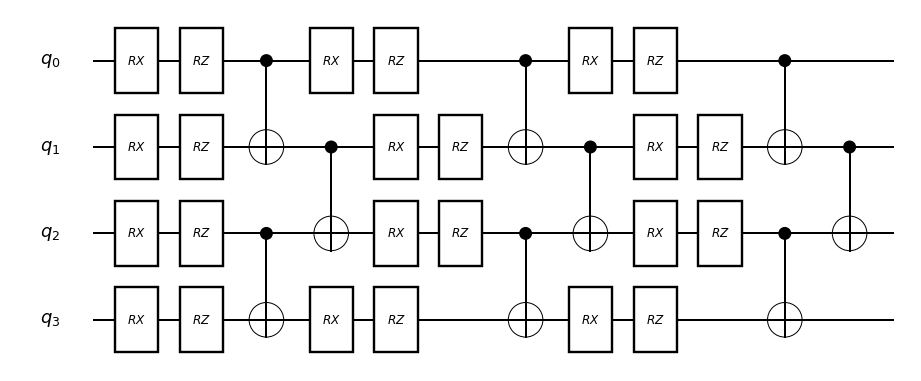

In [6]:
#本コードで利用しているansatzの構造を確認している

num_qubit = 4

### layer数
rep_layer = 3

num_params_layer = num_qubit*2
num_params = num_params_layer * rep_layer

print('num site : '+str(num_site))
print('num_params_layer : '+str(num_params_layer))
print('num_params : '+str(num_params))

params_init = np.random.rand(num_params)*2*np.pi
circuit = make_ansatz_hea(parameters=params_init, num_qubit=num_qubit, num_params_layer=num_params_layer, rep_layer=rep_layer)
print(f'circuit depth : {circuit.calculate_depth()}')
circuit_drawer(circuit,'mpl')

### qubit数によるBarren plateau

In [ ]:
list_num_qubit = [2,4,6,8,10,12,14]

### ansatz内のlayerの繰り返し回数。上げるほど量子状態の表現能力が高まる。
rep_layer = 20

method = 'SLSQP'
num_trial = 50
maxiter = 10000
array_var_hea = []
list_var_hea_mean = []
list_var_hea_std = []
for i_num_qubit in list_num_qubit:
    observable = Observable(i_num_qubit)
    observable.add_operator(1., f"Z 0 Z 1")
    
    gcalc = GradCalculator()

    list_var_hea = []
    i_num_params_layer = i_num_qubit*2
    i_num_params = i_num_params_layer * rep_layer

    print('num qubit : '+str(i_num_qubit))
    print('num_params_layer : '+str(i_num_params_layer))
    print('num_params : '+str(i_num_params))
    for i_trial in range(num_trial):
        var_hea = 0.
        params_init = np.random.rand(i_num_params)*2*np.pi
        circuit = make_parametric_ansatz(parameters=params_init, num_qubit=i_num_qubit, num_params_layer=i_num_params_layer, rep_layer=rep_layer)
        var_hea = gcalc.calculate_grad(circuit, observable)
        list_var_hea.append(var_hea[0]**2)
    array_var_hea.append(list_var_hea)

array_var_hea = np.array(array_var_hea)
list_var_hea_mean = array_var_hea.mean(axis=1)
list_var_hea_std = array_var_hea.std(axis=1)

for i,i_var in enumerate(list_var_hea_mean):
    print(f"{i} qubit mean variance : {i_var}")


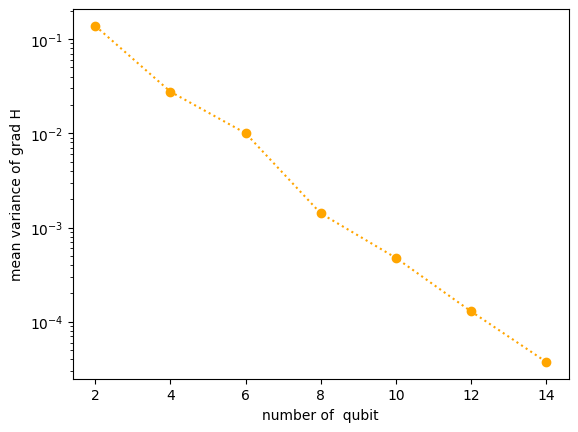

In [42]:
plt.plot(list_num_qubit, list_var_hea_mean, ":o", label='variance', color='orange')
plt.yscale('log')
plt.xlabel('number of  qubit')
plt.ylabel('mean variance of grad H')
plt.show()

### Layer数によるBarren plateau

In [ ]:
list_num_qubit = [2,4,6,8,10]

### ansatz内のlayerの繰り返し回数。上げるほど量子状態の表現能力が高まる。
rep_layer = [2,4,8,10,15,30,60,120,180,240,300]

method = 'SLSQP'
num_trial = 50
array_var_hea = []
list_var_hea_mean = []
list_var_hea_std = []
for i_num_qubit in list_num_qubit:
    observable = Observable(i_num_qubit)
    observable.add_operator(1., f"Z 0 Z 1")
    
    gcalc = GradCalculator()

    list_var_hea = []
    for i_rep_layer in rep_layer:
        list_var_hea_rep = []
        i_num_params_layer = i_num_qubit*2
        i_num_params = i_num_params_layer * i_rep_layer

        print('num qubit : '+str(i_num_qubit))
        print('num_params_layer : '+str(i_num_params_layer))
        print('num_params : '+str(i_num_params))
        for i_trial in range(num_trial):
            var_hea = 0.
            params_init = np.random.rand(i_num_params)*2*np.pi
            circuit = make_parametric_ansatz(parameters=params_init, num_qubit=i_num_qubit, num_params_layer=i_num_params_layer, rep_layer=i_rep_layer)
            var_hea = gcalc.calculate_grad(circuit, observable)
            list_var_hea_rep.append(var_hea[0]**2)
        
        list_var_hea.append(list_var_hea_rep)

    array_var_hea.append(list_var_hea)

array_var_hea = np.array(array_var_hea)
list_var_hea_mean = array_var_hea.mean(axis=2)
list_var_hea_std = array_var_hea.std(axis=2)

for i in range(len(list_var_hea_mean)):
    for j,j_var in enumerate(list_var_hea_mean):
        print(f"{list_num_qubit[i]} qubit {rep_layer[j]} layer mean variance : {j_var}")


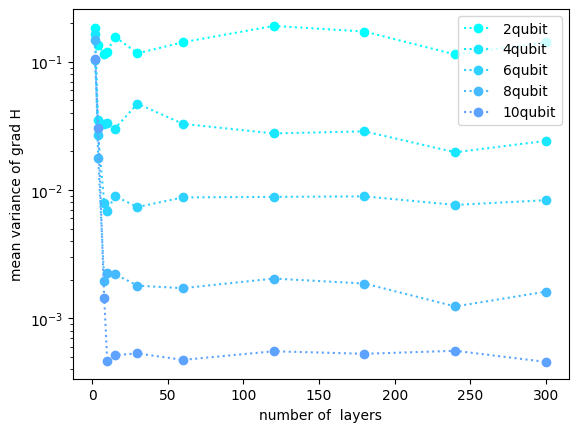

In [64]:
color_map = plt.get_cmap("cool")
for i in range(len(list_var_hea_mean)):
    plt.plot(rep_layer, list_var_hea_mean[i],":o", label=f'{list_num_qubit[i]}qubit', color=color_map(i/len(list_var_hea_mean[i])))
plt.yscale('log')
plt.xlabel('number of  layers')
plt.ylabel('mean variance of grad H')
plt.legend()
plt.show()